
## Image Captioning with Conditioned LSTM Generators


### Getting Started 

First, run the following commands to make sure you have all required packages. 

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import keras
import re
import string
import cv2
import json
import pickle
import collections
from keras.applications.resnet import ResNet50, preprocess_input
# from keras.preprocessing import image
from keras.models import Model, load_model
from keras_preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from keras.layers import Embedding, LSTM, Dense, Input, Bidirectional, RepeatVector, Concatenate, Activation

from keras.applications.inception_v3 import InceptionV3

from tensorflow.keras.optimizers import Adam

# from keras.layers.merge import add


### Access to the flickr8k data

We will use the flickr8k data set, described here in more detail: 

> M. Hodosh, P. Young and J. Hockenmaier (2013) "Framing Image Description as a Ranking Task: Data, Models and Evaluation Metrics", Journal of Artificial Intelligence Research, Volume 47, pages 853-899 http://www.jair.org/papers/paper3994.html

Dataset: https://www.kaggle.com/datasets/adityajn105/flickr8k

You need to download the dataset and then upload it again to your own drive. Please assign the name you choose for this folder to the variable `my_data_dir` in the next cell.


In [ ]:
#this is where you put the name of your data folder.
#Please make sure it's correct because it'll be used in many places later.
my_data_dir="dataset"

### Mounting your GDrive so you can access the files from Colab (optional)

In [ ]:
#running this command will generate a message that will ask you to click on a link where you'll obtain your GDrive auth code.
#copy paste that code in the text box that will appear below
drive.mount('/content/gdrive')

Please look at the 'Files' tab on the left side and make sure you can see the 'hw5_data' folder that you have in your GDrive.

## Part I: Understand the data (10 pts)

> Indented block



Read the caption file:

In [10]:
def readTxtFile(path):
    with open(path) as f:
        captions = f.read()
    return captions

In [3]:
# read from the input that contains captions of each image
# captions = readTxtFile("../input/flickr8k/captions.txt")
captions = pd.read_csv(f'captions.txt')
print(captions.shape)
captions.head()

(40455, 2)


image  \
0  1000268201_693b08cb0e.jpg   
1  1000268201_693b08cb0e.jpg   
2  1000268201_693b08cb0e.jpg   
3  1000268201_693b08cb0e.jpg   
4  1000268201_693b08cb0e.jpg   

                                             caption  
0  A child in a pink dress is climbing up a set o...  
1              A girl going into a wooden building .  
2   A little girl climbing into a wooden playhouse .  
3  A little girl climbing the stairs to her playh...  
4  A little girl in a pink dress going into a woo...

Train, test split:

In [ ]:
# TODO: train, test split: 0.8: 0.2

Each entry is an image filename.

In [ ]:
train_df.head()

Check an example:

If you can't see the image, try

In [ ]:
plt.imshow(image)

## Part II: Image encoder (10 pts)
We are going to use an off-the-shelf pre-trained image encoder, the Inception V3 network. The model is a version of a convolution neural network for object detection. Here is more detail about this model (not required for this project): 

> Szegedy, C., Vanhoucke, V., Ioffe, S., Shlens, J., & Wojna, Z. (2016). Rethinking the inception architecture for computer vision. In Proceedings of the IEEE conference on computer vision and pattern recognition (pp. 2818-2826).
> https://www.cv-foundation.org/openaccess/content_cvpr_2016/html/Szegedy_Rethinking_the_Inception_CVPR_2016_paper.html

The model requires that input images are presented as 299x299 pixels, with 3 color channels (RGB). The individual RGB values need to range between 0 and 1.0. The flickr images don't fit. 

In [ ]:
np.asarray(image).shape

The values range from 0 to 255. 

We can use PIL to resize the image and then divide every value by 255. 

Let's put this all in a function for convenience. 

In [ ]:
def read_image(image_name):
    image = Image.open(os.path.join('Images', image_name))
    return np.asarray(image.resize((299,299))) / 255.0                     

Next, we load the pre-trained Inception model. 

In [ ]:
img_model = InceptionV3(weights='imagenet') # This will download the weight files for you and might take a while.

In [ ]:
img_model.summary() # this is quite a complex model. 

This is a prediction model,so the output is typically a softmax-activated vector representing 1000 possible object types. Because we are interested in an encoded representation of the image we are just going to use the second-to-last layer as a source of image encodings. Each image will be encoded as a vector of size 2048. 

We will use the following hack: hook up the input into a new Keras model and use the penultimate layer of the existing model as output.

In [ ]:
new_input = img_model.input
new_output = img_model.layers[-2].output
img_encoder = Model(new_input, new_output) # This is the final Keras image encoder model we will use.

**TODO:** We will need to create encodings for all images and store them in one big matrix (one for each dataset, train, test).
We can then save the matrices so that we never have to touch the bulky image data again. 

To save memory (but slow the process down a little bit) we will read in the images lazily using a generator. We will encounter generators again later when we train the LSTM. If you are unfamiliar with generators, take a look at this page: https://wiki.python.org/moin/Generators

Write the following generator function, which should return one image at a time. 
`img_list` is a list of image file names (i.e. the train, dev, or test set). The return value should be a numpy array of shape (1,299,299,3).

In [ ]:
def img_generator(img_list):
    n=len(img_list)
    i=0
    while(i<n-1):
        re_img=read_image(img_list.iloc[i])
        re_img=np.reshape(re_img,(1,299,299,3))
        yield re_img       
        i+=1

In [ ]:
enc_train = img_encoder.predict(img_generator(train_list), steps=len(train_list), verbose=1)

In [ ]:
enc_train.shape

In [ ]:
enc_test = img_encoder.predict(img_generator(test_list), steps=len(test_list), verbose=1)

It's a good idea to save the resulting matrices, so we do not have to run the encoder again. 

In [ ]:
np.save(f"encoded_images_train.npy", enc_train)
np.save(f"encoded_images_test.npy", enc_test)

## Part III Text (Caption) Data Preparation (10 pts)

Next, we need to load the image captions and generate training data for the generator model.

In [ ]:
### Reading image descriptions

**TODO**: Write the following function that reads the image descriptions from the file `filename` and returns a dictionary in the following format. Take a look at the file `Flickr8k.token.txt` for the format of the input file. Data from https://github.com/text-machine-lab/MUTT/tree/master/data/flickr

The keys of the dictionary should be image filenames. Each value should be a list of 5 captions. Each caption should be a list of tokens.  

The captions in the file are already tokenized, so you can just split them at white spaces. You should convert each token to lower case. You should then pad each caption with a START token on the left and an END token on the right. 

In [ ]:
def read_image_descriptions(filename):    
    image_descriptions = defaultdict(list)
    # TODO: here
    with open("captions.txt") as f:
        data = f.read()
        for val in data.split("\n"):            
            tokens = val.lower().split(".jpg,")
            image_id, image_desc= tokens[0],tokens[1:]
            image_desc=['<START>']+image_desc+['<END>']
            if image_id in image_descriptions:
                image_descriptions[image_id].append(image_desc)
            else:
                image_descriptions[image_id] = list()
                image_descriptions[image_id].append(image_desc)    
        return image_descriptions

In [ ]:
# Populating description dictionary using the above method
descriptions = read_image_descriptions(f"Flickr8k.token.txt")

In [ ]:
print(descriptions[train_list[0]])

Running the previous cell should print similar to this:     
`[['<START>', 'a', 'child', 'in', 'a', 'pink', 'dress', 'is', 'climbing', 'up', 'a', 'set', 'of', 'stairs', 'in', 'an', 'entry', 'way', '.', '<END>'], ['<START>', 'a', 'girl', 'going', 'into', 'a', 'wooden', 'building', '.', '<END>'], ['<START>', 'a', 'little', 'girl', 'climbing', 'into', 'a', 'wooden', 'playhouse', '.', '<END>'], ['<START>', 'a', 'little', 'girl', 'climbing', 'the', 'stairs', 'to', 'her', 'playhouse', '.', '<END>'], ['<START>', 'a', 'little', 'girl', 'in', 'a', 'pink', 'dress', 'going', 'into', 'a', 'wooden', 'cabin', '.', '<END>']]
`    

In [ ]:
example_file = train_df.iloc[9]['image']
cap = train_df.iloc[9]['caption']
image = Image.open(os.path.join('Images', example_file))
print(image.size)
print(cap)

In [4]:
captions = captions[1:-1] 

In [5]:
captions=captions.values.tolist()

In [6]:
print(len(captions))
print(captions[0])
print(captions[1])
print(captions[2])
# captions[0].split(".jpg,")

40453
['1000268201_693b08cb0e.jpg', 'A girl going into a wooden building .']
['1000268201_693b08cb0e.jpg', 'A little girl climbing into a wooden playhouse .']
['1000268201_693b08cb0e.jpg', 'A little girl climbing the stairs to her playhouse .']


In [7]:
# dictionary to map image ids with their respective captions
from collections import defaultdict
def read_image_descriptions(filename):    
    image_descriptions = defaultdict(list)
    # TODO: here
    with open("captions.txt") as f:
        data = f.read()
        for val in data.split("\n"):            
            tokens = val.lower().split(".jpg,")
            image_id, image_desc= tokens[0],tokens[1:]
            image_desc=['<START>']+image_desc+['<END>']
#             image_id=image_id[:-2]        
            # check if image_id is already present or not
            if image_id in image_descriptions:
                image_descriptions[image_id].append(image_desc)
            else:
                image_descriptions[image_id] = list()
                image_descriptions[image_id].append(image_desc)    
        return image_descriptions
# descriptions = {}

# for x in captions:
#         img_name, img_desc = s.split(".jpg,")
#         # if the img_name is not present
#         if descriptions.get(img_name) is None:
#             descriptions[img_name] = []
#         descriptions[img_name].append(img_desc)

In [26]:
# checking if we got our dictionary correctly
# we have 5 captions for each image in the dataset
descriptions=read_image_descriptions("a")
descriptions["1000268201_693b08cb0e"]

[['<START>',
  'a child in a pink dress is climbing up a set of stairs in an entry way .',
  '<END>'],
 ['<START>', 'a girl going into a wooden building .', '<END>'],
 ['<START>', 'a little girl climbing into a wooden playhouse .', '<END>'],
 ['<START>', 'a little girl climbing the stairs to her playhouse .', '<END>'],
 ['<START>',
  'a little girl in a pink dress going into a wooden cabin .',
  '<END>']]

In [27]:
type(descriptions)

collections.defaultdict

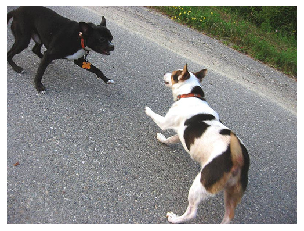

[['<START>', 'a black dog and a spotted dog are fighting', '<END>'],
 ['<START>',
  'a black dog and a tri-colored dog playing with each other on the road .',
  '<END>'],
 ['<START>',
  'a black dog and a white dog with brown spots are staring at each other in the street .',
  '<END>'],
 ['<START>',
  'two dogs of different breeds looking at each other on the road .',
  '<END>'],
 ['<START>', 'two dogs on pavement moving toward each other .', '<END>']]

In [28]:
IMG_PATH = "../dataset/Images/"

def readImg(imgId):
    img = cv2.imread(IMG_PATH + imgId + ".jpg")# checking our image with a id
    # since cv2 reads our image in bgr format, we convert it to RGB
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.imshow(img)
    plt.axis('off')
    #plt.title(descriptions[imgId][0])
    plt.show()
readImg("1001773457_577c3a7d70")
descriptions["1001773457_577c3a7d70"]

In [20]:
descriptions["1001773457_577c3a7d70"]

[['<START>', 'a black dog and a spotted dog are fighting', '<END>'],
 ['<START>',
  'a black dog and a tri-colored dog playing with each other on the road .',
  '<END>'],
 ['<START>',
  'a black dog and a white dog with brown spots are staring at each other in the street .',
  '<END>'],
 ['<START>',
  'two dogs of different breeds looking at each other on the road .',
  '<END>'],
 ['<START>', 'two dogs on pavement moving toward each other .', '<END>']]

In [21]:
# save our newly made dictionary after cleaning
# so that we can save time for large datasets
with open("descriptions.txt", "w") as f:
    f.write(str(descriptions))

In [29]:
print(type(descriptions))

<class 'collections.defaultdict'>


In [37]:
# vocab = set()
# for key in descriptions.keys():
#     # for each sentence we split it into words and pass it to set vocab from descriptions dictionary
#     [vocab.update(sentence.split()) for sentence in descriptions[key]]
# print("Vocab Size : %d"% len(vocab))
voca = set()
for key in descriptions.keys():
    for d in descriptions[key]:
        s=' '.join(d)
        vocab.update(s.split(" "))
print('Original Vocabulary Size: %d' % len(vocab))

Original Vocabulary Size: 9182


In [38]:
total_words = []
for key in descriptions.keys():
    for des in descriptions[key]:        
        s=' '.join(d)
        for i in s.split(" "):
            total_words.append(i)
print("Total Word %d"%len(total_words))

Total Word 80914


In [39]:
counter = collections.Counter(total_words)
freq_count = dict(counter)

In [40]:
# sort our frequency count based on value
sorted_freq_count = sorted(freq_count.items(), reverse=True, key=lambda x : x[1])
threshold_freq = 10
# we reject all the words whose frequency is less than 10
sorted_freq_count = [x for x in sorted_freq_count if x[1] > threshold_freq]
total_words = [x[0] for x in sorted_freq_count]

In [41]:
print(len(total_words)) # final vocab size

2


In [42]:
data = []
for k in descriptions.keys():
    data.append(k)
print(len(data))

8093


In [67]:
data=data[1:]
data

['1001773457_577c3a7d70',
 '1002674143_1b742ab4b8',
 '1003163366_44323f5815',
 '1007129816_e794419615',
 '1007320043_627395c3d8',
 '1009434119_febe49276a',
 '1012212859_01547e3f17',
 '1015118661_980735411b',
 '1015584366_dfcec3c85a',
 '101654506_8eb26cfb60',
 '101669240_b2d3e7f17b',
 '1016887272_03199f49c4',
 '1019077836_6fc9b15408',
 '1019604187_d087bf9a5f',
 '1020651753_06077ec457',
 '1022454332_6af2c1449a',
 '1022454428_b6b660a67b',
 '1022975728_75515238d8',
 '102351840_323e3de834',
 '1024138940_f1fefbdce1',
 '102455176_5f8ead62d5',
 '1026685415_0431cbf574',
 '1028205764_7e8df9a2ea',
 '1030985833_b0902ea560',
 '103106960_e8a41d64f8',
 '103195344_5d2dc613a3',
 '103205630_682ca7285b',
 '1032122270_ea6f0beedb',
 '1032460886_4a598ed535',
 '1034276567_49bb87c51c',
 '104136873_5b5d41be75',
 '1042020065_fb3d3ba5ba',
 '1042590306_95dea0916c',
 '1045521051_108ebc19be',
 '1048710776_bb5b0a5c7c',
 '1052358063_eae6744153',
 '105342180_4d4a40b47f',
 '1053804096_ad278b25f1',
 '1055623002_8195a437

Train, test split:

In [68]:
splitSize = int(0.8 * len(data))
train_data = data[ : splitSize]
test_data = data[splitSize : ]
print(len(train_data), len(test_data))

6472 1619


In [69]:
train_descriptions = {}
for img_id in train_data:
    train_descriptions[img_id] = []
    for cap in descriptions[img_id]:
        cap_ = "<START>" + " ".join(cap) + " <END>"
        train_descriptions[img_id].append(cap_)

In [70]:
train_descriptions["1001773457_577c3a7d70"]
# each sentence has 'startseq' and 'endseq'

['<START><START> a black dog and a spotted dog are fighting <END> <END>',
 '<START><START> a black dog and a tri-colored dog playing with each other on the road . <END> <END>',
 '<START><START> a black dog and a white dog with brown spots are staring at each other in the street . <END> <END>',
 '<START><START> two dogs of different breeds looking at each other on the road . <END> <END>',
 '<START><START> two dogs on pavement moving toward each other . <END> <END>']

In [50]:
# we want to create a use the CONV model but upto the global average pooling layer
model_new = Model(model.input, model.layers[-2].output)

In [55]:
from tensorflow.keras.utils import load_img, img_to_array
def preprocess_img(img):
    img = load_img(img, target_size=(224,224))
    img = img_to_array(img)
    img = np.expand_dims(img, axis=0) # [Batchsize, 224, 224, 3] extend 3d tensor to 4d
    # Normalisation
    img = preprocess_input(img)
    return img

In [57]:
def encode_img(img):
    img = preprocess_img(img) # preprocess the image and normalize it
    feature_vector = model_new.predict(img) # passing through resnet conv layers
    # print(feature_vector.shape) # (1, 2048)
    feature_vector = feature_vector.reshape((-1,))
    return feature_vector

In [58]:
encode_img(IMG_PATH+"1001773457_577c3a7d70.jpg")

1/1 [==============================] - 1s 1s/step


array([0.7841802 , 0.8189695 , 0.06491411, ..., 0.08858445, 0.6853811 ,
       0.18749642], dtype=float32)

In [62]:
descriptions

defaultdict(list,
            {'image,caption': [['<START>', '<END>']],
             '1000268201_693b08cb0e': [['<START>',
               'a child in a pink dress is climbing up a set of stairs in an entry way .',
               '<END>'],
              ['<START>', 'a girl going into a wooden building .', '<END>'],
              ['<START>',
               'a little girl climbing into a wooden playhouse .',
               '<END>'],
              ['<START>',
               'a little girl climbing the stairs to her playhouse .',
               '<END>'],
              ['<START>',
               'a little girl in a pink dress going into a wooden cabin .',
               '<END>']],
             '1001773457_577c3a7d70': [['<START>',
               'a black dog and a spotted dog are fighting',
               '<END>'],
              ['<START>',
               'a black dog and a tri-colored dog playing with each other on the road .',
               '<END>'],
              ['<START>',
            

In [71]:
from time import time
encoding_train = {}
# img_id -> feature_vector
start_t = time()
for i, img_id in enumerate(train_data):
    img_path = IMG_PATH+img_id+".jpg"
    encoding_train[img_id] = encode_img(img_path)
    
    if i%100==0:
        print("Encoding Progress %d"%i)
end_t = time()
print("Total Time Taken :", end_t-start_t)

1/1 [==============================] - 0s 129ms/step
Encoding Progress 0
1/1 [==============================] - 0s 119ms/step
Encoding Progress 100
1/1 [==============================] - 0s 119ms/step
Encoding Progress 200
1/1 [==============================] - 0s 124ms/step
Encoding Progress 300
1/1 [==============================] - 0s 120ms/step
Encoding Progress 400
1/1 [==============================] - 0s 131ms/step
Encoding Progress 500
1/1 [==============================] - 0s 128ms/step
Encoding Progress 600
1/1 [==============================] - 0s 122ms/step
Encoding Progress 700
1/1 [==============================] - 0s 125ms/step
Encoding Progress 800
1/1 [==============================] - 0s 122ms/step
Encoding Progress 900
1/1 [==============================] - 0s 121ms/step
Encoding Progress 1000
1/1 [==============================] - 0s 124ms/step
Encoding Progress 1100
1/1 [==============================] - 0s 122ms/step
Encoding Progress 1200
1/1 [===================

In [72]:
# store the trained data from the resnet locally
encoding_train["1001773457_577c3a7d70"]

array([0.7841802 , 0.8189695 , 0.06491411, ..., 0.08858445, 0.6853811 ,
       0.18749642], dtype=float32)

In [73]:
with open("encoded_train_features.pkl","wb") as f:
    pickle.dump(encoding_train, f)

In [74]:
encoding_test = {}
# img_id -> feature_vector
start_t = time()
for i, img_id in enumerate(test_data):
    img_path = IMG_PATH+img_id+".jpg"
    encoding_test[img_id] = encode_img(img_path)
    
    if i%100==0:
        print("Encoding Progress %d"%i)
end_t = time()
print("Total Time Taken :", end_t-start_t)

1/1 [==============================] - 0s 230ms/step
Encoding Progress 0
1/1 [==============================] - 0s 214ms/step
Encoding Progress 100
1/1 [==============================] - 0s 223ms/step
Encoding Progress 200
1/1 [==============================] - 0s 224ms/step
Encoding Progress 300
1/1 [==============================] - 0s 233ms/step
Encoding Progress 400
1/1 [==============================] - 0s 245ms/step
Encoding Progress 500
1/1 [==============================] - 0s 251ms/step
Encoding Progress 600
1/1 [==============================] - 0s 241ms/step
Encoding Progress 700
1/1 [==============================] - 0s 234ms/step
Encoding Progress 800
1/1 [==============================] - 0s 242ms/step
Encoding Progress 900
1/1 [==============================] - 0s 250ms/step
Encoding Progress 1000
1/1 [==============================] - 0s 254ms/step
Encoding Progress 1100
1/1 [==============================] - 0s 261ms/step
Encoding Progress 1200
1/1 [===================

FileNotFoundError: [Errno 2] No such file or directory: '../dataset/Images/.jpg'

In [75]:
with open("encoded_test_features.pkl", "wb") as f:
    pickle.dump(encoding_test, f)

In [76]:
# vocab
len(total_words)

2

In [78]:
# word_to_index = {}
# index_to_word = {}
# for i, word in enumerate(total_words):
#     word_to_index[word] = i+1;
#     index_to_word[i+1] = word 
index_to_word = {}
word_to_index = {}
ix = 1
for w in vocab:
    word_to_index[w] = ix
    index_to_word[ix] = w
    ix += 1

In [79]:
print(word_to_index["on"], index_to_word[7])

4430 peacefully


In [114]:
index_to_word[1846] = "<START>"
word_to_index["<START>"] = 1846

index_to_word[1847] = "<END>"
word_to_index["<endseq>"] = 1847

vocab_size = len(word_to_index) + 1
print(vocab_size)

9186


In [81]:
pickle
max_len = 0
for key in train_descriptions.keys():
    for cap in train_descriptions[key]:
        max_len = max(max_len, len(cap.split()))
print(max_len)

41


## Part IV Basic Decoder Model (20 pts)

For now, we will just train a model for text generation without conditioning the generator on the image input. 

There are different ways to do this and our approach will be slightly different from the generator discussed in class. 

The core idea here is that the Keras recurrent layers (including LSTM) create an "unrolled" RNN. Each time-step is represented as a different unit, but the weights for these units are shared. We are going to use the constant MAX_LEN to refer to the maximum length of a sequence, which turns out to be 40 words in this data set (including START and END).

In [ ]:
max(len(description) for image_id in train_list for description in descriptions[image_id])

In class, we discussed LSTM generators as transducers that map each word in the input sequence to the next word. 
<img src="http://www.cs.columbia.edu/~bauer/4705/lstm1.png" width="480px">

nstead, we will use the model to predict one word at a time, given a partial sequence. For example, given the sequence ["START","a"], the model might predict "dog" as the most likely word. We are basically using the LSTM to encode the input sequence up to this point. 
<img src="http://www.cs.columbia.edu/~bauer/4705/lstm2.png" width="480px">


To train the model, we will convert each description into a set of input output pairs as follows. For example, consider the sequence 

`['<START>', 'a', 'black', 'dog', '.', '<END>']`

We would train the model using the following input/output pairs 

| i | input                        | output |
|---|------------------------------|--------|
| 0 |[`START`]                     | `a`    |  
| 1 |[`START`,`a`]                 | `black`|
| 2 |[`START`,`a`, `black`]        | `dog`  |
| 3 |[`START`,`a`, `black`, `dog`] | `END`  |



### Creating a Generator for the Training Data

**TODO**: 

We could simply create one large numpy ndarray for all the training data. Because we have a lot of training instances (each training sentence will produce up to MAX_LEN input/output pairs, one for each word), it is better to produce the training examples *lazily*, i.e. in batches using a generator (recall the image generator in part I). 

Write the function `text_training_generator` below, that takes as a paramater the batch_size and returns an `(input, output)` pair. `input` is a `(batch_size, MAX_LEN)` ndarray of partial input sequences, `output` contains the next words predicted for each partial input sequence, encoded as a `(batch_size, vocab_size)` ndarray.

Each time the next() function is called on the generator instance, it should return a new batch of the *training* data. You can use `train_list` as a list of training images. A batch may contain input/output examples extracted from different descriptions or even from different images. 

You can just refer back to the variables you have defined above, including `descriptions`, `train_list`, `vocab_size`, etc. 


Hint: To prevent issues with having to reset the generator for each epoch and to make sure the generator can always return exactly `batch_size` input/output pairs in each step, wrap your code into a `while True:` loop. This way, when you reach the end of the training data, you will just continue adding training data from the beginning into the batch. 

In [82]:
# data generator
def data_generator(train_descriptions, encoding_train, word_to_index, max_len, batch_size):
    X1, X2, y = [], [], [] #image vector X1, partial vector X2, target word y
    n = 0
    while True:
        for key, desc_list in train_descriptions.items():
            n += 1
            photo = encoding_train[key]
            for capt in desc_list:
                seq = [word_to_index[word] for word in capt.split() if word in word_to_index]
                for i in range(1, len(seq)):
                    xi = seq[0:i]
                    yi = seq[i]
                    
                    # zero padding
                    # returns a 2d matrix
                    xi = pad_sequences([xi], maxlen=max_len, value=0, padding='post')[0]
                    yi = to_categorical([yi], num_classes=vocab_size)[0]
                    
                    X1.append(photo)
                    X2.append(xi)
                    y.append(yi)
                if n == batch_size:
                    yield ([np.array(X1), np.array(X2)], np.array(y))
                    X1, X2, y = [], [], []
                    n = 0

## Part V - Conditioning on the Image (20 pts)

We will now extend the model to condition the next word not only on the partial sequence, but also on the encoded image. 

We will project the 2048-dimensional image encoding to a 300-dimensional hidden layer. 
We then concatenate this vector with each embedded input word, before applying the LSTM.

Here is what the Keras model looks like: 

In [86]:
embedding_index = {}
for line in f:
    values = line.split()
    word = values[0]
    word_embedding = np.array(values[1:],dtype='float')
    embedding_index[word] = word_embedding
f.close()

In [87]:
embedding_index['boy']

array([-0.32345 ,  0.23332 , -0.20082 , -0.52848 ,  1.0926  ,  0.62445 ,
       -0.99859 ,  0.28085 ,  0.088326,  0.36919 ,  0.32199 ,  0.3499  ,
        0.067459,  0.24211 ,  0.92565 , -0.32581 , -0.99134 ,  0.80767 ,
       -0.22845 ,  0.40076 , -0.8577  ,  1.3836  ,  0.056439,  0.76561 ,
        0.3608  , -2.0692  , -0.46679 ,  0.12359 ,  0.35127 , -0.77092 ,
        2.2064  , -0.42605 , -0.24279 ,  0.3832  ,  0.6069  ,  0.62835 ,
        0.31825 , -0.8851  ,  0.38329 , -1.146   , -0.41949 ,  0.2606  ,
       -0.6568  , -0.11511 ,  1.0591  , -0.61148 ,  0.32152 , -1.3182  ,
        0.31744 ,  0.02527 ])

In [88]:
def get_embedding_matrix():
    emb_dim = 50
    matrix = np.zeros((vocab_size, emb_dim))
    for word, idx in word_to_index.items():
        embedding_vector = embedding_index.get(word)
        
        if embedding_vector is not None:
            matrix[idx] = embedding_vector
    return matrix

In [89]:
embedding_matrix = get_embedding_matrix()
embedding_matrix.shape

(9185, 50)

# Model Architecture

image features and partial sequence ----> |model| ---->  next word in seq


In [90]:
input_img_features = Input(shape=(2048,))
input_img1 = Dropout(0.3)(input_img_features)
input_img = Dense(256, activation='relu')(input_img1)


In [91]:
input_captions = Input(shape=(max_len, ))
input_cap1 = Embedding(input_dim = vocab_size, output_dim = 50, mask_zero=True)(input_captions)
input_cap2 = Dropout(0.3)(input_cap1)
input_cap = LSTM(256)(input_cap2) # output size 256

In [97]:
from keras.layers import add
decoder1 = add([input_img, input_cap])
decoder2 = Dense(256, activation='relu')(decoder1)
outputs = Dense(vocab_size, activation='softmax')(decoder2)

In [98]:
model = Model(inputs=[input_img_features, input_captions], outputs=outputs)

In [99]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 41)]         0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, 2048)]       0           []                               
                                                                                                  
 embedding (Embedding)          (None, 41, 50)       459250      ['input_3[0][0]']                
                                                                                                  
 dropout (Dropout)              (None, 2048)         0           ['input_2[0][0]']                
                                                                                            

In [100]:
model.layers[2].set_weights([embedding_matrix])
model.layers[2].trainable = False # pre trained using transfer learning

In [101]:
model.compile(loss='categorical_crossentropy', optimizer='adam')

In [102]:
epochs = 20
batch_size = 3
steps = len(train_descriptions)//batch_size

for i in range(epochs):
    generator = data_generator(train_descriptions, encoding_train, word_to_index, max_len, batch_size)
    model.fit_generator(generator, epochs=1, steps_per_epoch=steps, verbose=1)
    model.save('./model_weights/model_'+str(i)+'.h5')

C:\Users\Aunsh Arekar\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  import sys


2157/2157 [==============================] - 2263s 1s/step - loss: 1.9720


In [103]:
model = load_model('./model_weights/model_6.h5')

In [115]:
def image_decoder(enc_image):
    text = "<START>"
    for i in range(max_len):
        sequence = [word_to_index[w] for w in text.split() if w in word_to_index]
        sequence = pad_sequences([sequence], maxlen=max_len, padding='post')
        yPred = model.predict([photo, sequence])
        yPred = yPred.argmax()
        word = index_to_word[yPred]
        text += (' '+ word)
        if word == '<END>':
            break
    
    final_caption = text.split()[1:-1]
    final_caption = ' '.join(final_caption)
    return final_caption

1/1 [==============================] - 0s 34ms/step
in relatively water , one is flapping out of the water ."
['<START>', 'a brown dog holding a buoy in its mouth in the water', '<END>']


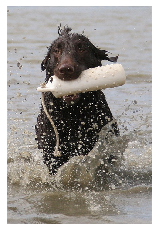

1/1 [==============================] - 0s 33ms/step
plane booths , banners and banners ."
['<START>', 'a firetruck fights a fire .', '<END>']


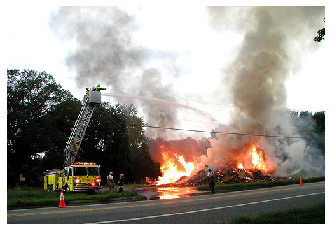

1/1 [==============================] - 0s 36ms/step
people supporting in front of a building , one is taking a sign ."
['<START>', 'a few girls on a woooden pier eating ice cream cones', '<END>']


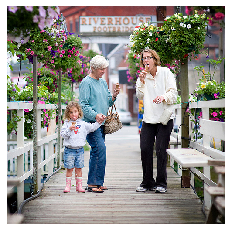

1/1 [==============================] - 0s 34ms/step
motorcycle , including cyclists , one is driving a dirt bike ."
['<START>', 'a dirt bike rider rides off of a jump .', '<END>']


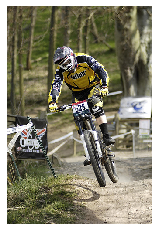

1/1 [==============================] - 0s 39ms/step
motorcycle , one on a motorcycle , one one one on the ground ."
['<START>', 'a dirt biker is riding through deep sand and dirt .', '<END>']


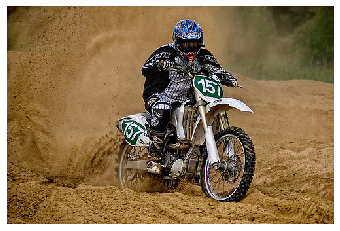

1/1 [==============================] - 0s 34ms/step
man in a black shirt , and a woman in a black shirt , and a woman in a black shirt , and a woman in a black shirt , and a woman in a black shirt , and a
['<START>', 'a bald man stands in a snowy side street .', '<END>']


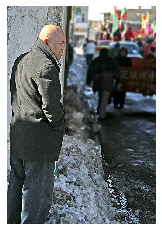

1/1 [==============================] - 0s 35ms/step
"" "" , one in the air , pitching to kick the ball ."
['<START>', 'the three field hockey players are all chasing the ball .', '<END>']


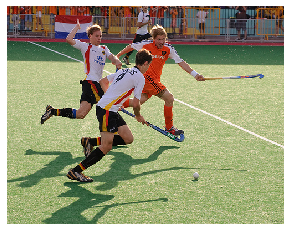

1/1 [==============================] - 0s 36ms/step
is visible in the air , hovering out of the water ."
['<START>', 'a man jumps off of a dock and into the water .', '<END>']


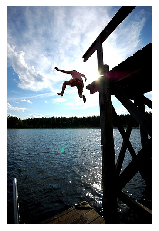

1/1 [==============================] - 0s 33ms/step
of people , one is kayaking through the water ."
['<START>', 'a kayaker plungles into the river .', '<END>']


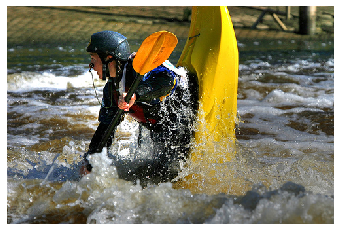

1/1 [==============================] - 0s 39ms/step
dogs , one brown and white , and one black and white and white and white and white , and one black and white , and one black and white and white and white and white , are playing in
['<START>', 'a brown dog and a gray dog are playing in the snow .', '<END>']


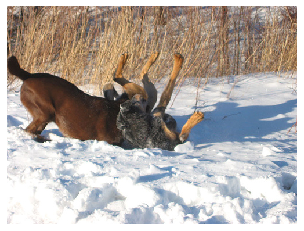

In [116]:
for i in range(10):
    idx = np.random.randint(0,1000)
    all_img = list(encoding_test.keys())
    img_name = all_img[idx]
    photo = encoding_test[img_name].reshape((1,2048))
    lol = plt.imread(IMG_PATH+img_name+'.jpg')
    caption = predict_caption(photo)
    print(caption)
    print(descriptions[img_name][0])
    plt.imshow(lol)
    plt.axis('off')
    plt.show()

## Part VII Beam search (10 pts)

**TODO**: Use beam search algorithm to refine the output captions.

Reference: https://keras.io/api/keras_nlp/utils/beam_search/

https://keras.io/examples/nlp/text_generation_gpt/

In [ ]:
**TODO**: Randomly plot 10 images with captions from train set and test set each.

In [117]:
def beam_search_predictions(image, beam_index = 3):
    start = [word_to_index["<START>"]]
    start_word = [[start, 0.0]]
    while len(start_word[0][0]) < max_len:
        temp = []
        for s in start_word:
            par_caps = pad_sequences([s[0]], maxlen=max_len, padding='post')
            preds = model.predict([image,par_caps], verbose=0)
            word_preds = np.argsort(preds[0])[-beam_index:]
            for w in word_preds:
                next_cap, prob = s[0][:], s[1]
                next_cap.append(w)
                prob += preds[0][w]
                temp.append([next_cap, prob])
                    
        start_word = temp
        start_word = sorted(start_word, reverse=False, key=lambda l: l[1])
        start_word = start_word[-beam_index:]
    
    start_word = start_word[-1][0]
    intermediate_caption = [index_to_word[i] for i in start_word]
    final_caption = []
    
    for i in intermediate_caption:
        if i != '<END>':
            final_caption.append(i)
        else:
            break

    final_caption = ' '.join(final_caption[1:])
    return final_caption

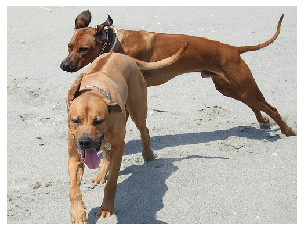

Beam Search: dogs , one brown and white , and a brown and white dog are running in the snow ."


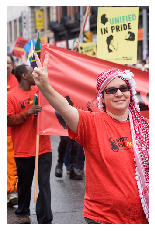

Beam Search: "" "" ""


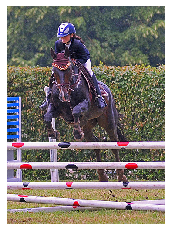

Beam Search: on a bike , while others watch ."


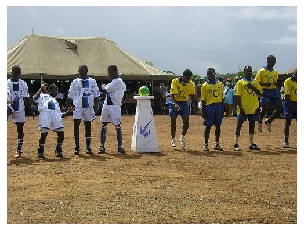

Beam Search: "" ""


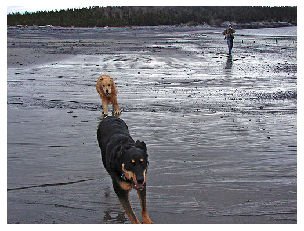

Beam Search: dogs , one in the water ."


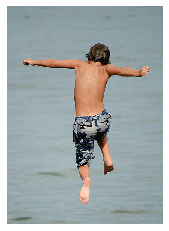

Beam Search: man in a red shirt , and a boy in a blue shirt , and a boy in a blue shirt , and a boy in a blue shirt , and a boy in a blue shirt and black shorts


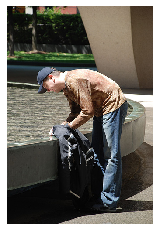

Beam Search: man in a blue shirt , jeans , and a man in a blue shirt ."


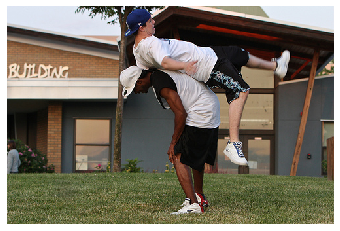

Beam Search: man in a white shirt , a man in a black shirt , and a man in a black shirt , and a man in a black shirt , and a man in a black shirt , and a man


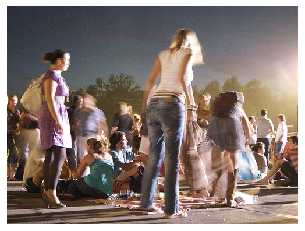

Beam Search: "" ""


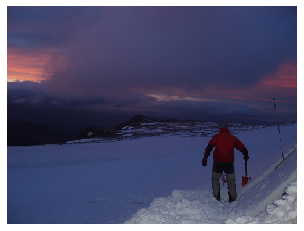

Beam Search: skiing down a snowy mountain .


In [118]:
# from test set
for i in range(10):
    idx = np.random.randint(0,1000)
    all_img = list(encoding_test.keys())
    img_name = all_img[idx]
    image = encoding_test[img_name].reshape((1,2048))
    lol = plt.imread(IMG_PATH+img_name+'.jpg')
    plt.imshow(lol)
    plt.axis('off')
    plt.show()
    print("Beam Search:",beam_search_predictions(image, beam_index = 3))


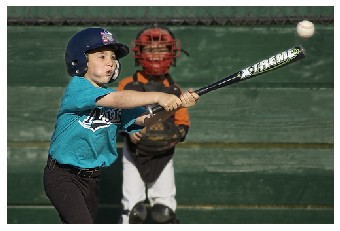

Caption: man wearing a white shirt , and knee is holding a bat in his hand ."


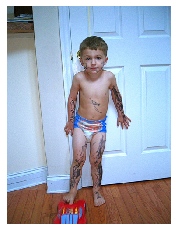

Caption: woman in a red shirt , and a woman in a blue shirt , and a woman in a blue shirt , and a woman in a blue shirt ."


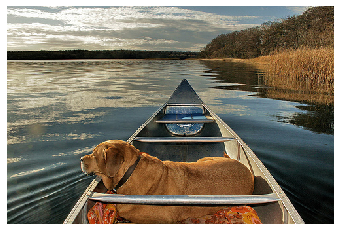

Caption: in the water , splashing in the water ."


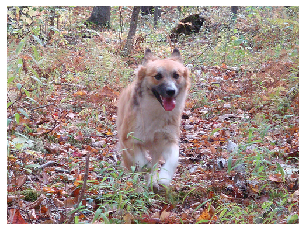

Caption: brown dog is running through the water with a stick in its mouth ."


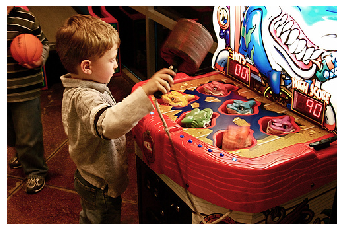

Caption: of people are sitting on a desk with a drum in the background ."


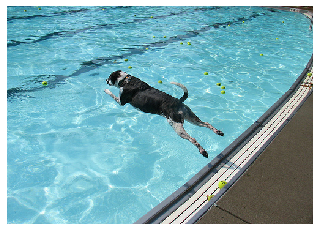

Caption: and birds , one in the water ."


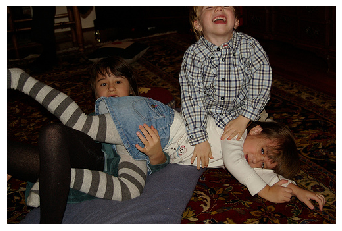

Caption: man in a red robe , and a woman in a black jacket , holding a guitar ."


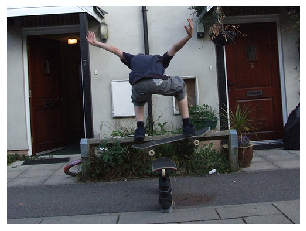

Caption: man wearing a black robe , black shirt , and a man in a black shirt , and a man in the background ."


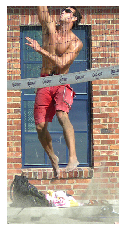

Caption: man in a blue shirt , sandals , and a boy in a blue shirt , and a boy in a blue shirt , and a boy in a blue shirt , and a boy in a blue shirt ,


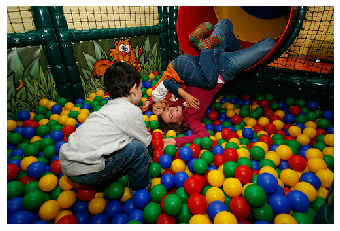

Caption: of children are playing on a playground equipment , balloons streamers streamers ."


In [121]:
# from train set
for i in range(10):
    idx = np.random.randint(0,1000)
    all_img = list(encoding_train.keys())
    img_name = all_img[idx]
    image = encoding_train[img_name].reshape((1,2048))
    lol = plt.imread(IMG_PATH+img_name+'.jpg')
    plt.imshow(lol)
    plt.axis('off')
    plt.show()
    print("Caption:",beam_search_predictions(image, beam_index = 3))


As we can see some of the captions are reasonably good and some of them are way off the mark. What we can do to improve this is instead of considering the entire vocabulary of the captions we can just consider the words which appear frequently. And also increasing the number of epochs to make the model train more can result in some increase in accuracy.

References

https://www.kaggle.com/code/daskoushik/imagecaptioning
https://www.kaggle.com/code/adhoppin/image-caption-generator
https://github.com/albazahm/Flickr-8k_Image_Captioning
https://towardsdatascience.com/image-captioning-with-keras-teaching-computers-to-describe-pictures-c88a46a311b8
